# Apêndice A.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

## Importações.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import sys
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras
from keras import layers


tf.test.gpu_device_name()

flag = 1 #treinar modelo
flag = 0 #carregar modelo !! (Comente para treinar e salvar)

2021-09-03 22:59:58.835863: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-03 22:59:58.835885: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-03 22:59:59.918761: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-03 22:59:59.919194: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-03 22:59:59.919316: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so

## Configurações.

In [3]:
input_shape = (128,128,3)
batch = 32

## Importação do Dataset.

In [4]:
BASE_PATH = ['../..','datasets']
DATASET_DIR=['PKLot','output']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],
                           DATASET_DIR[0],DATASET_DIR[1])


X = tf.keras.preprocessing.image_dataset_from_directory(DATASET_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        seed=1, color_mode='rgb', validation_split=0.3, subset = 'training')


X_val = tf.keras.preprocessing.image_dataset_from_directory(DATASET_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        seed=1, color_mode='rgb', validation_split=0.3, subset = 'validation')


print('\nClasses: {} em {}'.format(X.class_names,DATASET_DIR))

Found 58747 files belonging to 2 classes.
Using 41123 files for training.


2021-09-03 23:00:01.016239: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-03 23:00:01.016443: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


Found 58747 files belonging to 2 classes.
Using 17624 files for validation.

Classes: ['livre', 'ocupada'] em ../../datasets/PKLot/output


## Construindo o modelo e compilando.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0

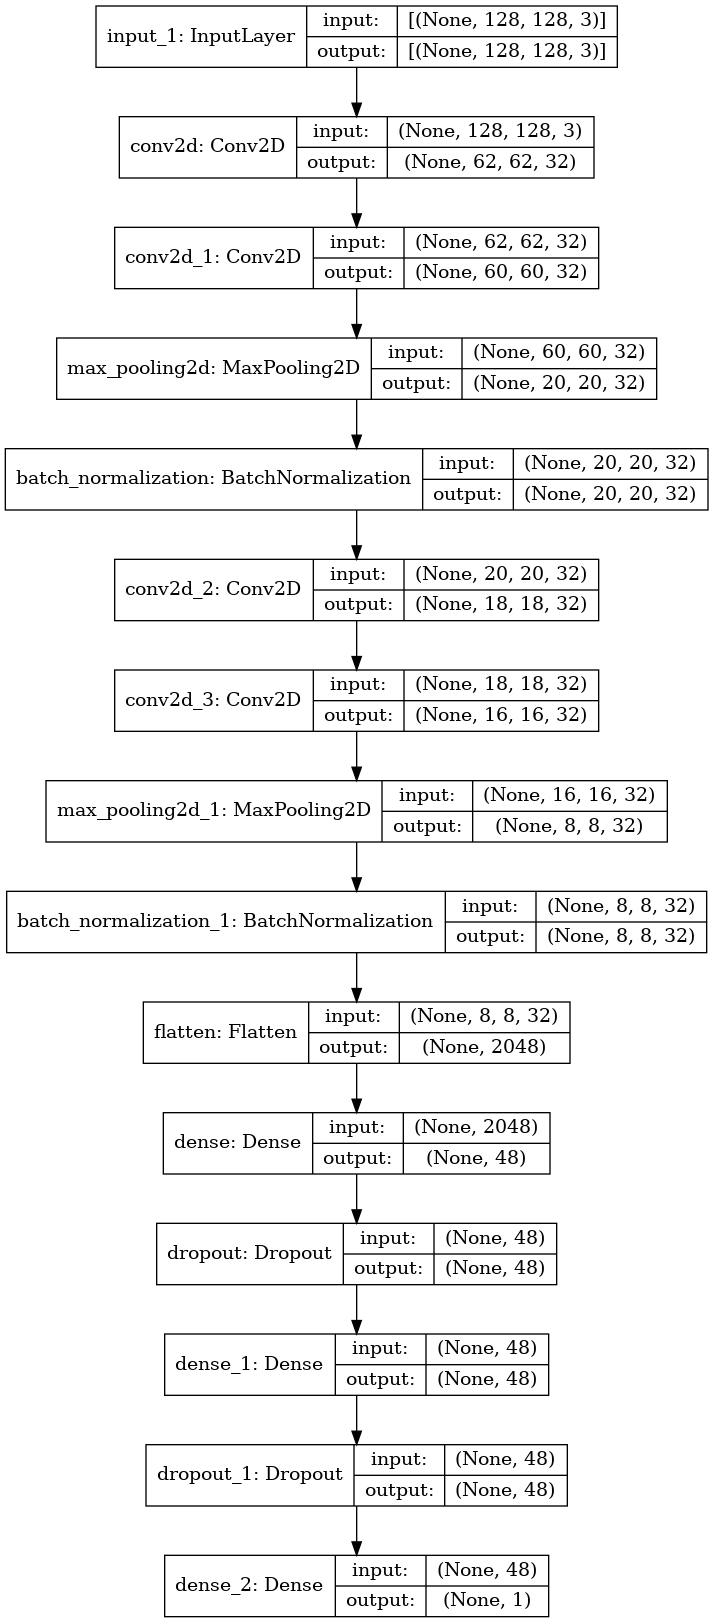

In [5]:
def modelo():
    model = keras.Sequential(
    [
        layers.InputLayer(input_shape),
        layers.Conv2D(filters=32,kernel_size=5,strides=2, activation="relu"),
        layers.Conv2D(32, 3, activation="relu"),
        layers.MaxPooling2D(pool_size=3),
        layers.BatchNormalization(),
        
        layers.Conv2D(32,3, activation="relu"),
        layers.Conv2D(32,3, activation="relu"),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(48,activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(48,activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid"),
    ]
)

    return model

model = modelo()

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
keras.utils.plot_model(model, "./images/arquitetura.png", show_shapes=True)

## Testando os Labels carregadas da base de treinamento.

2021-09-03 23:00:02.297685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-03 23:00:02.318681: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz


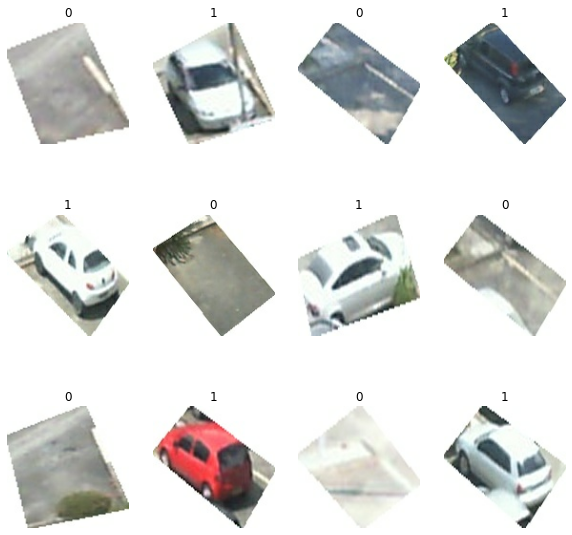

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in X.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Exemplo de Imagem não segmentada.

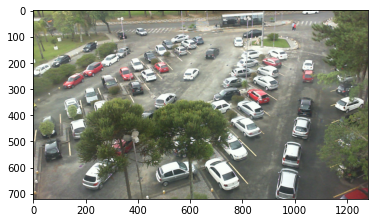

In [7]:
img_full = os.path.join(BASE_PATH[0],BASE_PATH[1],
                        'PKLot','UFPR04','Sunny','todas','2012-12-07_17_12_25.jpg')

img_full = plt.imread(img_full)
plt.imshow(img_full)

## Treinando o modelo.

In [8]:
%%time

if flag:
    model.fit(X, epochs=5)
else:
    LOAD_DIR = os.path.split(DATASET_DIR)[0] # Separa (head,tail) -> Indice [0] = head
    LOAD_DIR = os.path.join(LOAD_DIR,'model')

    model = keras.models.load_model(LOAD_DIR)
    

CPU times: user 586 ms, sys: 34.3 ms, total: 620 ms
Wall time: 618 ms


## Validação do modelo treinado. (testando na base de dados de validação)

In [9]:
score = model.evaluate(X_val, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

551/551 - 26s - loss: 0.1383 - accuracy: 0.9657
Test loss: 0.13833291828632355
Test accuracy: 0.9657285809516907


## Salvando o modelo treinado.

In [10]:
if flag:
    SAVE_DIR = os.path.split(DATASET_DIR)[0] # Separa (head,tail) -> Indice [0] = head
    SAVE_DIR = os.path.join(SAVE_DIR,'model')
    model.save(
        SAVE_DIR,
        overwrite=False,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
        save_traces=True,
    )

## Validação individual (random) na base de treinamento

Vaga livre: 0.05 porcento.
Vaga ocupada 99.95 porcento.


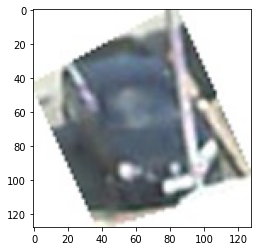

In [11]:
path = X.file_paths[np.random.randint(len(X.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

#plot = plt.imread(path)
#plt.imshow(img,cmap='gray')
plt.imshow(img)

## Validação individual (random) no Banco de testes

Vaga livre: 0.00 porcento.
Vaga ocupada 100.00 porcento.


array([0.99999964], dtype=float32)

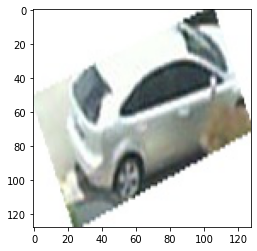

In [12]:
path = X_val.file_paths[np.random.randint(len(X_val.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

#plot = plt.imread(path)
plt.imshow(img)

score

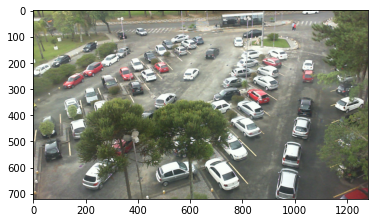

In [13]:
plt.imshow(img_full)

In [14]:
BASE_PATH = ['../..','datasets']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],'PKLot')

path = '/PKLot/UFPR04/Sunny/todas'
path = os.path.normpath(path)
path = path.split(os.sep)

IMAGE_DIR = os.path.join(DATASET_DIR,path[2],path[3],path[4])
XML_DIR = IMAGE_DIR


IMAGE_PATH = []
XML_PATH = []
def criarLista():
    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".jpg"):

            file = os.path.join(IMAGE_DIR,file)
            IMAGE_PATH.append(file)
    IMAGE_PATH.sort()

    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".xml"):

            file = os.path.join(XML_DIR,file)
            XML_PATH.append(file)
    XML_PATH.sort()


criarLista()
#debug
print(IMAGE_DIR)
print(XML_DIR)
print(IMAGE_PATH[:2])
print(XML_PATH[:2])

../../datasets/PKLot/UFPR04/Sunny/todas
../../datasets/PKLot/UFPR04/Sunny/todas
['../../datasets/PKLot/UFPR04/Sunny/todas/2012-12-07_17_12_25.jpg', '../../datasets/PKLot/UFPR04/Sunny/todas/2012-12-07_17_17_25.jpg']
['../../datasets/PKLot/UFPR04/Sunny/todas/2012-12-07_17_12_25.xml', '../../datasets/PKLot/UFPR04/Sunny/todas/2012-12-07_17_17_25.xml']


In [15]:
tree = ET.parse(XML_PATH[0])
root = tree.getroot()

pts = np.empty(0,np.int32)
vaga = np.empty(0,np.int32)

for neighbor in root.iter('point'):
    #print(neighbor.attrib)
    x,y = neighbor.attrib.values()
    x = int(x)
    y = int(y)
    a = [x,y]
    pts = np.append(pts,[x,y])
    
for neighbor in root.iter('space'):
    #print(neighbor.attrib)
    if(len(neighbor.attrib.values())==2):
        _,occupied = neighbor.attrib.values()
        occupied = int(occupied)
    if(len(neighbor.attrib.values())==1):
        occupied=0
        
    vaga = np.append(vaga,occupied)

#debug
print(pts[0:4])
print(vaga[0:10])

paresXY = np.array(np.zeros((112,2)),np.int32) 
j=0
for i in range(112):
    paresXY[i] = pts[j:j+2]
    j = j+2

#debug
paresXY[0:4]

[720 549 805 665]
[1 1 1 1 1 1 1 1 1 1]


array([[720, 549],
       [805, 665],
       [715, 698],
       [644, 582]], dtype=int32)

In [16]:
def crop(j=0,i=0,vaga=2,lista=5):
    rect = cv2.boundingRect(paresXY[j:j+4])
    x,y,w,h = rect
    croped = im2[y:y+h, x:x+w].copy()

    pts = paresXY[j:j+4] - paresXY[j:j+4].min(axis=0)
    mask = np.zeros(croped.shape[:2], croped.dtype)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask) #background preto

    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst #background branco
    
    image = cv2.resize(dst2, (128,128), interpolation = cv2.INTER_CUBIC)
    
    img = image.copy()
    cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,  0)

    predictions = model.predict(img_array)
    score = predictions[0]
    score = float(score)
    return score
    

In [17]:
def juntar(im,im2,scale=80):
    
    img = np.hstack((im2, im))
    
    scale_percent = scale # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)  
    return resized

In [26]:
for i in range (10): #só repetição
    
    sort = np.random.randint(len(IMAGE_PATH))
    im = cv2.imread(IMAGE_PATH[sort])
    im2 = im.copy()
    if im is None:
        sys.exit("A imagem não foi carregada.")

    j=0
    for i in range(len(paresXY)//4):

        score = crop(j,i,vaga[i])
        #print(score)
        if((score)<0.7):
            cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
            print(score)
        j=j+4



    img_junta = juntar(im,im2,70)

    cv2.imshow(IMAGE_PATH[sort], img_junta)
    k = cv2.waitKey(5000)
    cv2.destroyAllWindows()
# if k == ord('q'):
#     cv2.destroyAllWindows()

#image = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
#plt.imshow(image)

0.6791446208953857
2.5275156076531857e-05
0.004721105098724365
0.0006354153156280518
3.973326602135785e-05
0.0008608102798461914
1.66112367878668e-05
0.0001341700553894043
5.843058170285076e-05
0.00470009446144104
0.024506807327270508
0.012215524911880493
0.0029841363430023193
0.00045225024223327637
0.0007359087467193604
0.002424180507659912
0.0002631247043609619
0.6714236736297607
0.05342492461204529
0.1096106767654419
3.703157290146919e-06
1.271358360099839e-05
0.0002696216106414795
0.4493142366409302
0.00046131014823913574
0.00416332483291626
0.0026738643646240234
0.02332422137260437
0.03985708951950073
0.1123296320438385
0.00265657901763916
0.056256651878356934
0.629673182964325
7.692434337513987e-06
3.1531126296613365e-05
0.0027228891849517822
5.6583357945783064e-05
7.978604116942734e-05
0.00012892484664916992
0.009915977716445923
7.360998552030651e-06
0.0006337463855743408
2.525790478102863e-05
0.4950942099094391
0.0022338032722473145
0.6019652485847473
0.00043201446533203125
7.0

In [19]:
np.random.randint(len(IMAGE_PATH))
    

105

In [20]:
np.random.randint(len(IMAGE_PATH))

549

## Debug 

In [27]:
len(paresXY)


112

ImagemCompleta = os.path.join(IMAGE_DIR,'2012-12-07_19_02_27.jpg')
im = cv2.imread(ImagemCompleta)

if im is None:
    sys.exit("A imagem não foi carregada.")


    
    




r = cv2.selectROI(im)
imCrop = im[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]

imCrop = im[389:508,995:1058] #(y1:y2,x1:x2)
#imCrop = cv2.resize(imCrop, (70,50), interpolation = cv2.INTER_AREA)

imCrop = im[190:260,995:1058] #(y1:y2,x1:x2)
imCrop = cv2.resize(imCrop, (70,50), interpolation = cv2.INTER_AREA)

#cv2.line(im,(720,549),(805,665),(255,0,0),5)
#cv2.line(im,(715,698),(644,582),(255,0,0),5)
#cv2.rectangle(im,(644,582),(805,665),(0,255,0),3)

pts = np.array([[0,0],[0,0],[0,0],[0,0]], np.int32)
pts[0:4] = [720,549],[805,665],[715,698],[644,582]

pts2 = np.array([[0,0],[0,0],[0,0],[0,0]], np.int32)
pts2[0:4] = [769,451],[849,534],[789,586],[701,489]
#pts = pts.reshape((-1,1,2))
#blank = np.zeros(im.shape[:2])
cv2.polylines(im,[pts],True,(0,255,255),5)
cv2.polylines(im,[pts2],True,(0,255,255),5)

<point x="769" y="451"/>
<point x="849" y="534"/>
<point x="789" y="586"/>
<point x="701" y="489"/>

cv2.imshow("Estacionamento", im)
k = cv2.waitKey(0)

if k == ord('q'):
    cv2.destroyAllWindows()

#img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(im)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
#score = predictions[0][0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

#plot = plt.imread(imCrop)
#plt.imshow(plot)

predictions


img_array = keras.preprocessing.image.img_to_array(imCrop)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
predictions

predictions[0][0]

score

In [21]:
len(IMAGE_PATH)

2098

pts[0:2]

pts

path2 = '/dataset2/PKLot/UFPR04/Sunny/2012-12-07'
path2 = os.path.normpath(path2)
path2 = path2.split(os.sep)

IMAGE_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],path2[1],path2[2],path2[3],path2[4],path2[5])

#!ls $IMAGE_DIR



ImagemCompleta = os.path.join(IMAGE_DIR,'2012-12-07_19_02_27.jpg')
im = cv2.imread(ImagemCompleta)

if im is None:
    sys.exit("A imagem não foi carregada.")


import xml.etree.ElementTree as ET

tree = ET.parse('/home/pedrodsk/datasets/dataset2/PKLot/UFPR04/Sunny/2012-12-07/2012-12-07_19_02_27.xml')
root = tree.getroot()

pts = np.empty(0,np.int32)

for neighbor in root.iter('point'):
    #print(neighbor.attrib)
    x,y = neighbor.attrib.values()
    x = int(x)
    y = int(y)
    a = [x,y]
    pts = np.append(pts,[x,y])


a = np.array(np.zeros((112,2)),np.int32)
j=0
for i in range(112):
    a[i] = pts[j:j+2]
    j = j+2

#a = np.array(np.zeros((4,2)),np.int32)
#a[0] = pts[0:2]
#a[1] = pts[2:4]
#a[2] = pts[4:6]
#a[4] = pts[6:8]

#pts = a[0:4]
#pts = pts.reshape((-1, 1, 2))
#roi = np.ones(im.shape, dtype='uint8')

#roi = im[549:698,644:720]
pts2 = np.array(np.zeros((112,2)),np.int32)
#pts = np.array([[0,0],[0,0],[0,0],[0,0]], np.int32)

pts2[0:4] = a[0:4]
pts2[4:8] = a[4:8]
#pts = pts.reshape((-1, 1, 2))

cv2.polylines(im,[pts2[0:4],pts2[4:8]],True,(0,255,255),3)
#cv2.rectangle(roi,(30,30),(370,370),255,1)
#bitwise_and = cv2.bitwise_and(vaga1,im)


a[0:4]

a = np.array(np.zeros((112,2)),np.int32)
j=0
for i in range(112):
    a[i] = pts[j:j+2]
    j = j+2

j=0
for k in range(28):
    #print(j)
    pts2[j:j+4] = a[j:j+4]
    cv2.polylines(im,[pts2[j:j+4]],True,(0,255,255),3)
    j=j+4
    

cv2.polylines(im,[pts2[4:8]],True,(0,255,0),3)


cv2.imshow("Estacionamento", im)

k = cv2.waitKey(0)

if k == ord('q'):
    cv2.destroyAllWindows()

cv2.imshow("Estacionamento", roi)
k = cv2.waitKey(0)

if k == ord('q'):
    cv2.destroyAllWindows()

a[0:4]

pts

img

img_array

import os

BASE_PATH = ['../..','datasets']
path2 = '/dataset2/PKLot/UFPR04/Sunny/2012-12-07'
path2 = os.path.normpath(path2)
path2 = path2.split(os.sep)

IMAGE_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],path2[1],path2[2],path2[3],path2[4],path2[5])

ImagemCompleta = os.path.join(IMAGE_DIR,'2012-12-07_19_02_27.jpg')

#im = cv2.imread("exemplo.png")
im = cv2.imread(ImagemCompleta)

if im is None:
    sys.exit("A imagem não foi carregada.")

#pts = np.array([[10,150],[150,100],[300,150],[350,100],[310,20],[35,10]])
i=2
pts2 = pts[16:18],pts[18:20],pts[20:22],pts[22:24]
pts2 = np.array(pts2)

rect = cv2.boundingRect(pts2)
x,y,w,h = rect
croped = im[y:y+h, x:x+w].copy()

pts2 = pts2 - pts2.min(axis=0)
mask = np.zeros(croped.shape[:2], croped.dtype)
cv2.drawContours(mask, [pts2], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)

tmp = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
_,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(dst)
rgba = [b,g,r, alpha]
masked_tr = cv2.merge(rgba,4)

#masked_tr = cv2.cvtColor(masked_tr, cv2.COLOR_BGR2GRAY)
image = cv2.resize(masked_tr, (128,128), interpolation = cv2.INTER_CUBIC)

cv2.imwrite('vaga1.png', image)
plt.axis('off')
plt.imshow(image)



path = '/home/pedrodsk/cursos/tcc/vaga1.png'
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2],grayscale=True)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

#plot = plt.imread(path)
plt.imshow(img)




image = np.reshape[128,128,3]

path = X.file_paths[np.random.randint(len(X.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array.shape

img_array = tf.expand_dims(img_array,  0)
img_array

img_array = tf.expand_dims(img_array,  0)

img